In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pmdarima as pm

In [167]:
data = pd.read_csv('https://raw.githubusercontent.com/percepcioneseconomicas/publicaciones/main/importancia/data.csv', parse_dates=True, dayfirst=True, index_col='periodo')
data = data[['ctotal', 'ipeco', 'gndi', 'ipsa', 'ipv', 'desempleo', 't1a3anos']]
data.columns = ['consumo', 'ipeco', 'ingreso', 'ipsa', 'ipv', 'desempleo', 'interes']
print(len(data))
data

213


,consumo,ipeco,ingreso,ipsa,ipv,desempleo,interes
periodo,,,,,,,
2001-12-01,11682.16852,56.446503,17836.11895,1183.12,NaN,8.6,NaN
2002-01-01,NaN,NaN,NaN,1153.01,NaN,8.8,29.65
2002-02-01,NaN,NaN,NaN,1144.39,NaN,9.1,29.63
2002-03-01,10721.47288,57.662833,17559.76044,1163.60,79.850477,9.6,23.39
2002-04-01,NaN,NaN,NaN,1137.83,NaN,9.6,25.99
...,...,...,...,...,...,...,...
2019-04-01,NaN,52.649247,NaN,5187.10,NaN,6.9,23.44
2019-05-01,NaN,55.493021,NaN,4977.09,NaN,7.1,22.63
2019-06-01,25164.77844,53.086611,37747.31839,5070.72,NaN,7.1,22.71


In [15]:
data.isna().sum()

consumo      142
ipeco         27
ingreso      142
ipsa           0
ipv          145
desempleo      0
interes        1
dtype: int64

In [16]:
data['ipeco'] = data['ipeco'].interpolate(method='linear', limit_area='inside')
data['consumo'] = data['consumo'].interpolate(method='linear', limit_area='inside')
data['ingreso'] = data['ingreso'].interpolate(method='linear', limit_area='inside')
data['ipv'] = data['ipv'].interpolate(method='linear', limit_area='inside')

In [168]:
data['g12consumo'] = data['consumo'].pct_change(periods=12)
data['g12consumo'].corr(data['ipeco'])

0.6386575825559246

Text(0, 0.5, 'Ipeco')

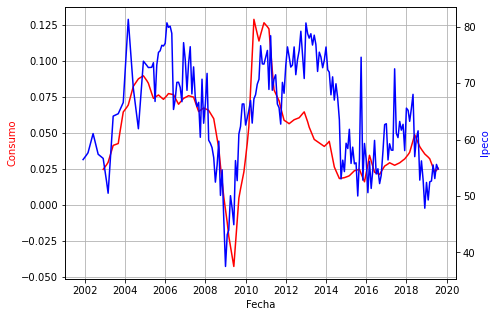

In [18]:
fig, ax1 = plt.subplots(figsize=(7,5))
ax1.plot(data['g12consumo'], color='red', linewidth=1.5)
ax1.set_xlabel('Fecha')
ax1.set_ylabel('Consumo', color='red')
plt.grid()
ax2 = ax1.twinx()
ax2.plot(data['ipeco'], color='blue', linewidth=1.5)
ax2.set_ylabel('Ipeco', color='blue')

In [19]:
y = data['consumo']
X = data[['ipeco', 'ingreso', 'ipsa', 'ipv', 'desempleo', 'interes']]

In [20]:
y = np.log(y)
X = np.log(X)

array([[<AxesSubplot:xlabel='periodo'>, <AxesSubplot:xlabel='periodo'>],
       [<AxesSubplot:xlabel='periodo'>, <AxesSubplot:xlabel='periodo'>],
       [<AxesSubplot:xlabel='periodo'>, <AxesSubplot:xlabel='periodo'>]],
      dtype=object)

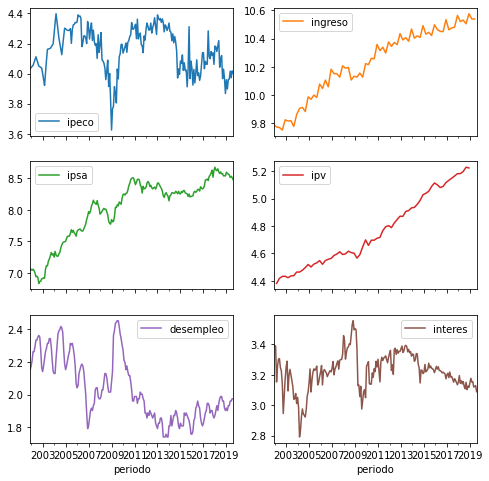

In [21]:
X.plot(subplots=True, layout=(3,2), figsize=(8,8))

In [22]:
X['ingreso'] = X['ingreso'].diff()
X['ipv'] = X['ipv'].diff()

In [23]:
X = X.shift()

In [24]:
X = X.dropna()
y = y[X.index]

In [68]:
model = pm.auto_arima(
    y=y,
    exogenous=X,
    d=1,  
    start_p=0, start_q=0,
    max_p=12, max_q=12,
    trace=True,
    error_action='ignore',
    suppress_warnings=True,
    information_criterion='aic',
    stepwise=True
    ) 

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1047.381, Time=0.57 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-1070.963, Time=0.64 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1047.490, Time=0.66 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1036.017, Time=0.40 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-1167.634, Time=0.62 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-1198.874, Time=0.83 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-1200.695, Time=0.94 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=-1198.858, Time=0.99 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-1198.553, Time=0.99 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-1194.484, Time=0.85 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=-1193.886, Time=1.19 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=-1188.830, Time=0.92 sec

Best model:  ARIMA(4,1,0)(0,0,0)[0] intercept
Total fit time: 9.603 seconds


In [146]:
bestModel = SARIMAX(endog=y, exog=X, order=(4,1,0), trend='c')
k = len(bestModel.param_names) - 2

results = bestModel.fit(maxiter=300, method='lbfgs')
n = results.nobs
pred = results.get_prediction(start=1)
r2 = pred.predicted_mean.corr(y)**2
adjr2 = 1 - (1 - r2)*((n-1)/(n-k-1))

print(results.summary())


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
                               SARIMAX Results                                
Dep. Variable:                consumo   No. Observations:                  201
Model:               SARIMAX(4, 1, 0)   Log Likelihood                 619.971
Date:                Mon, 29 Mar 2021   AIC                          -1215.942
Time:                        13:28:10   BIC                          -1176.362
Sample:                    05-01-2002   HQIC                         -1199.924
                         - 01-01-2019                                         
Covariance Type:                  opg              

In [145]:
print(results.summary().as_html())

<table class="simpletable">
<caption>SARIMAX Results</caption>
<tr>
  <th>Dep. Variable:</th>        <td>consumo</td>     <th>  No. Observations:  </th>    <td>201</td>   
</tr>
<tr>
  <th>Model:</th>           <td>SARIMAX(4, 1, 0)</td> <th>  Log Likelihood     </th>  <td>619.971</td> 
</tr>
<tr>
  <th>Date:</th>            <td>Mon, 29 Mar 2021</td> <th>  AIC                </th> <td>-1215.942</td>
</tr>
<tr>
  <th>Time:</th>                <td>13:27:45</td>     <th>  BIC                </th> <td>-1176.362</td>
</tr>
<tr>
  <th>Sample:</th>             <td>05-01-2002</td>    <th>  HQIC               </th> <td>-1199.924</td>
</tr>
<tr>
  <th></th>                   <td>- 01-01-2019</td>   <th>                     </th>     <td> </td>    
</tr>
<tr>
  <th>Covariance Type:</th>        <td>opg</td>       <th>                     </th>     <td> </td>    
</tr>
</table>
<table class="simpletable">
<tr>
      <td></td>         <th>coef</th>     <th>std err</th>      <th>z</th>      <th>P>|z|<

In [125]:
excluidas = ['ninguna']
adjr2s = [adjr2]

for e in X.columns:
    Z = X.drop(e, axis=1)
    model = SARIMAX(endog=y, exog=Z, order=(4,1,0), trend='c')
    k = len(model.param_names) - 2
    res  = model.fit(maxiter=400, method='lbfgs')
    n = res.nobs
    pred = res.get_prediction(start=1)
    r2 = pred.predicted_mean.corr(y)**2
    adjr2 = 1 - (1 - r2)*((n-1)/(n-k-1))

    excluidas.append(e)
    adjr2s.append(adjr2)

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Program

In [173]:
resultados = pd.Series(adjr2s, index=excluidas)
resultados.sort_values(ascending=False)

desempleo    0.998030
ninguna      0.998023
interes      0.998012
ipsa         0.998009
ipeco        0.998003
ipv          0.997929
ingreso      0.997769
dtype: float64

In [164]:
diferencia = resultados - resultados['ninguna']
diferencia = diferencia.sort_values(ascending=False)
diferencia = diferencia.drop('ninguna')
diferencia

desempleo    0.000007
interes     -0.000011
ipsa        -0.000014
ipeco       -0.000020
ipv         -0.000094
ingreso     -0.000254
dtype: float64

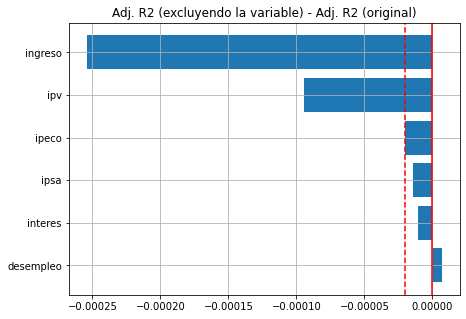

In [165]:
plt.figure(figsize=(7,5))
plt.barh(diferencia.index, diferencia)
plt.axvline(diferencia['ipeco'], color='red', linestyle='--')
plt.axvline(0, color='red')
plt.title('Adj. R2 (excluyendo la variable) - Adj. R2 (original)')
plt.grid()